In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import curve_fit


In [2]:
# constants
hbar = 6.582119569e-16
mu_B = 5.788381806e-5
A_hyperfine = 1e-6
thermal_noise_std = 0.01
T_dephasing = 2e-6

dt = 5e-9
steps = 400
times = dt * np.arange(steps)


In [3]:
# pauli matrices and operators
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)

def kron3(a, b, c):
    return np.kron(np.kron(a, b), c)

S1 = {'x': kron3(sx, I2, I2), 'y': kron3(sy, I2, I2), 'z': kron3(sz, I2, I2)}
S2 = {'x': kron3(I2, sx, I2), 'y': kron3(I2, sy, I2), 'z': kron3(I2, sz, I2)}
I  = {'x': kron3(I2, I2, sx), 'y': kron3(I2, I2, sy), 'z': kron3(I2, I2, sz)}

# singlet state
up = np.array([1, 0])
down = np.array([0, 1])
singlet_pair = (np.kron(up, down) - np.kron(down, up)) / np.sqrt(2)
singlet = np.kron(singlet_pair, up)
rho_0 = np.outer(singlet, singlet.conj())
P_S = np.outer(singlet, singlet.conj())


In [4]:
# mag. fields
fields = [
    {"B": np.array([0.0, 0.0, 0.0]), "label": "0 µT (z)", "color": "black"},
    {"B": np.array([0.0, 0.0, 50e-6]), "label": "50 µT (z)", "color": "orange"},
    {"B": np.array([50e-6, 0.0, 0.0]), "label": "50 µT (x)", "color": "green"},
]

results_clean = {}
results_noisy = {}

In [5]:
# clean and noisy
for field in fields:
    B = field["B"]
    label = field["label"]
    
    H_Z = mu_B * (B[0]*(S1['x']+S2['x']) + B[1]*(S1['y']+S2['y']) + B[2]*(S1['z']+S2['z']))
    H_HF = A_hyperfine * (S1['x'] @ I['x'] + S1['y'] @ I['y'] + S1['z'] @ I['z'])
    H = H_Z + H_HF
    U = expm(-1j * H * dt / hbar)

    rho_clean = rho_0.copy()
    rho_noisy = rho_0.copy()
    ps_clean = []
    ps_noisy = []

    for t in times:
        rho_clean = U @ rho_clean @ U.conj().T
        p_clean = np.trace(P_S @ rho_clean).real
        ps_clean.append(p_clean)

        rho_noisy = U @ rho_noisy @ U.conj().T
        p_noisy = np.trace(P_S @ rho_noisy).real
        damping = np.exp(-t / T_dephasing)
        noise = np.random.normal(0, thermal_noise_std)
        ps_noisy.append((p_noisy + noise) * damping)

    results_clean[label] = ps_clean
    results_noisy[label] = ps_noisy


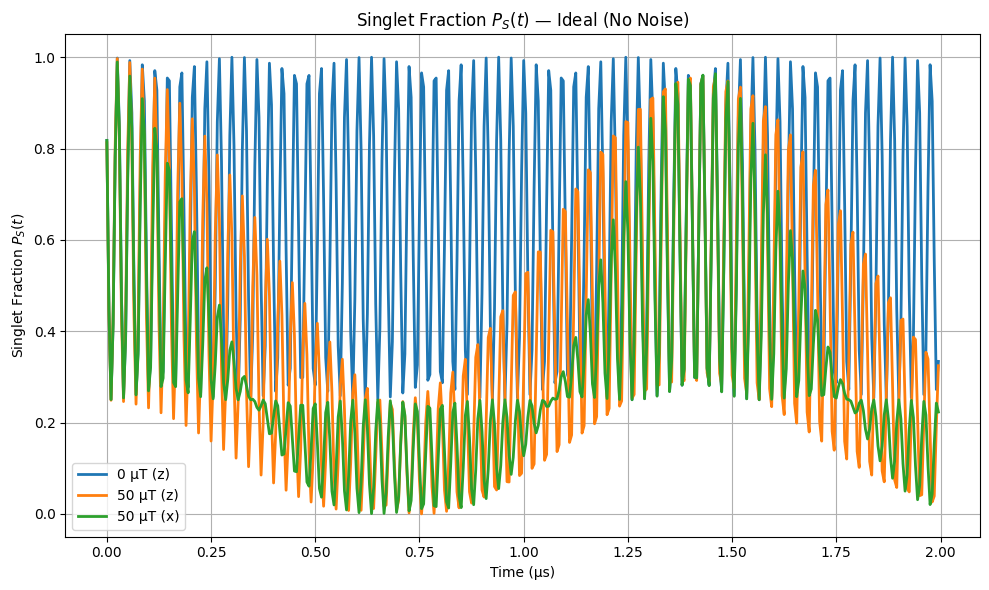

In [6]:
# ideal model
plt.figure(figsize=(10, 6))
for field in fields:
    label = field["label"]
    plt.plot(times * 1e6, results_clean[label], label=label, linewidth=2)
plt.title("Singlet Fraction $P_S(t)$ — Ideal (No Noise)")
plt.xlabel("Time (µs)")
plt.ylabel("Singlet Fraction $P_S(t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
def fit_func(t, A, omega, phi, tau, offset):
    return A * np.cos(omega * t + phi) * np.exp(-t / tau) + offset


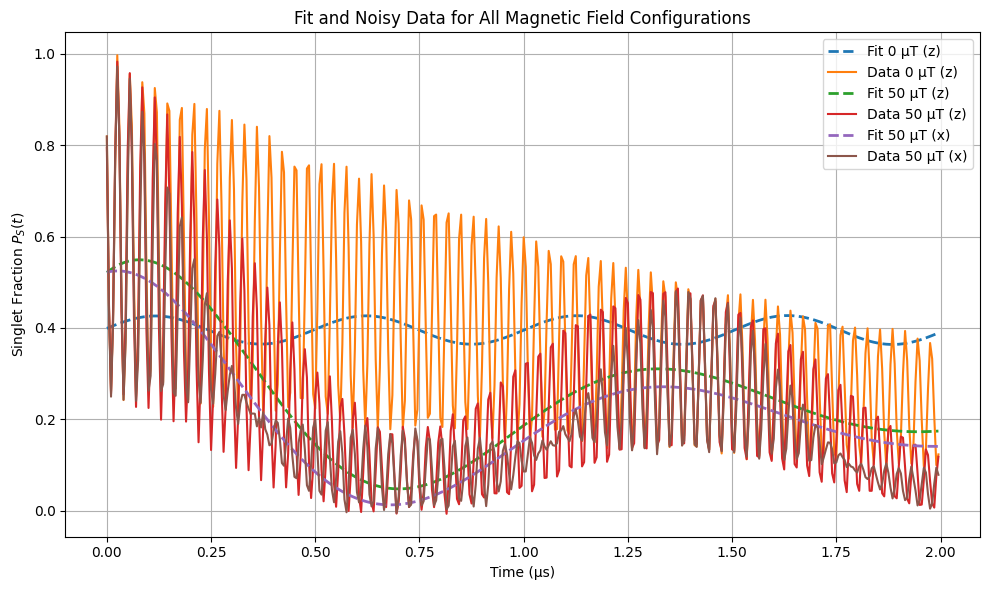

In [8]:
# noisy data and fits
plt.figure(figsize=(10, 6))
for field in fields:
    label = field["label"]
    y_vals = np.array(results_noisy[label])
    t_vals = times

    try:
        p0 = [0.5, 2*np.pi*2e6, 0, 2e-6, 0.5]
        popt, _ = curve_fit(fit_func, t_vals, y_vals, p0=p0, maxfev=10000)
        fit_curve = fit_func(t_vals, *popt)
        plt.plot(t_vals * 1e6, fit_curve, linestyle="--", linewidth=2, label=f"Fit {label}")
    except RuntimeError:
        pass

    plt.plot(t_vals * 1e6, y_vals, linewidth=1.5, label=f"Data {label}")

plt.title("Fit and Noisy Data for All Magnetic Field Configurations")
plt.xlabel("Time (µs)")
plt.ylabel("Singlet Fraction $P_S(t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
